In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-reviews-response/google_reviews_response/resp-from-review-train.csv
/kaggle/input/google-reviews-response/google_reviews_response/resp-from-review-test.csv
/kaggle/input/google-reviews-response/google_reviews_response/resp-from-review-validation.csv


In [2]:
!pip install datasets
!pip install transformers

In [3]:
from datasets import load_dataset, DatasetDict

import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
from transformers import create_optimizer

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
# Set the random seed
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
data_files = {
    "train": "/kaggle/input/google-reviews-response/google_reviews_response/resp-from-review-train.csv",
    "validation": "/kaggle/input/google-reviews-response/google_reviews_response/resp-from-review-validation.csv",
    "test": "/kaggle/input/google-reviews-response/google_reviews_response/resp-from-review-test.csv",
}
data = load_dataset("csv", data_files=data_files)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)
/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)
/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1ae3ad78ee91ec7e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
checkpoint = 'facebook/bart-large'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = TFAutoModelForSeq2SeqLM.from_pretrained(checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [8]:
print('MEAN REVIEW:', np.mean(data['train']['length_review']))
print('MEAN RESPONSE:', np.mean(data['train']['length_response']))

MEAN REVIEW: 45.89061490579561
MEAN RESPONSE: 32.87696484148724


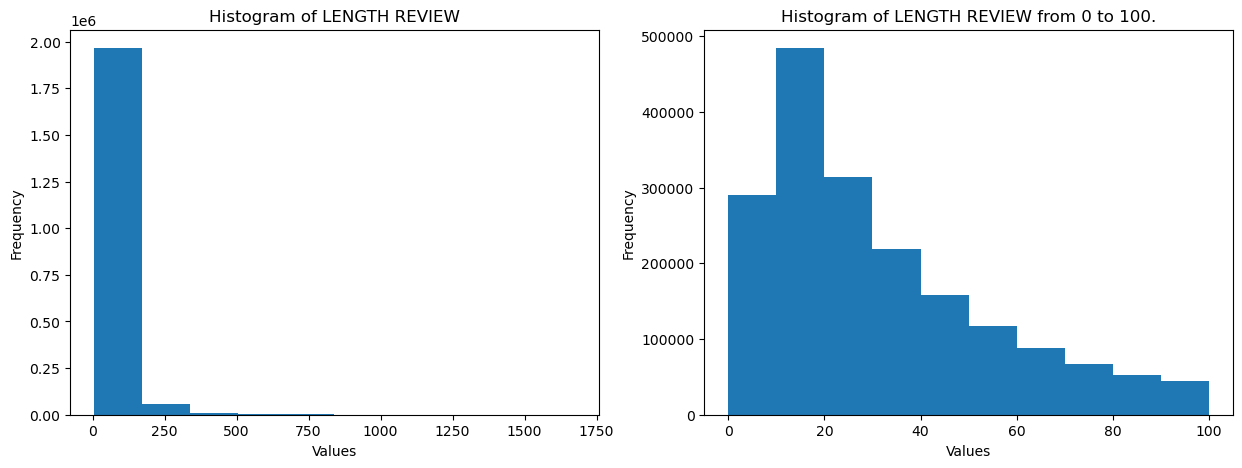

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(data['train']['length_review'], bins=10)
ax[0].set_xlabel('Values')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of LENGTH REVIEW')


ax[1].hist(data['train']['length_review'], bins=10, range=(0, 100))
ax[1].set_xlabel('Values')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of LENGTH REVIEW from 0 to 100.')


plt.show()

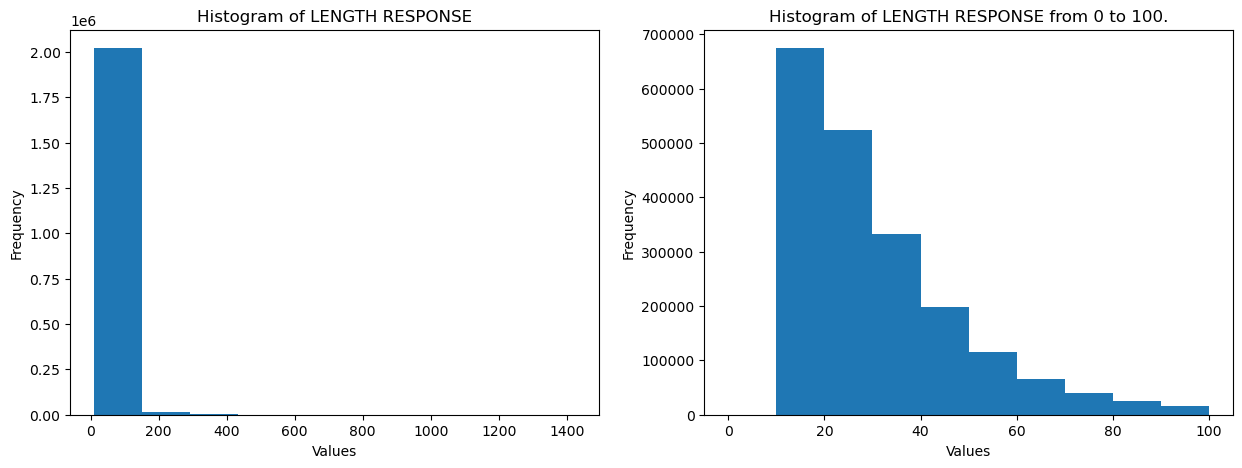

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(data['train']['length_response'], bins=10)
ax[0].set_xlabel('Values')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of LENGTH RESPONSE')


ax[1].hist(data['train']['length_response'], bins=10, range=(0, 100))
ax[1].set_xlabel('Values')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of LENGTH RESPONSE from 0 to 100.')


plt.show()

**FILTER DATA**

In [11]:
filter_data = data.filter(lambda example: (35 <= example['length_review'] <= 150) and (35 <= example['length_response'] <= 150))

  0%|          | 0/2038 [00:00<?, ?ba/s]

  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/204 [00:00<?, ?ba/s]

In [12]:
filter_data = filter_data.remove_columns(['name', 'rating', 'text', 'length_review', 'length_response'])

In [13]:
max_input_length = 150
max_target_length = 150


def preprocess_function(example):
    model_inputs = tokenizer(example["new_review"], max_length=max_input_length, truncation=True, padding=True)

    labels = tokenizer(example["resp_text"], max_length=max_target_length, truncation=True, padding=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [14]:
tokenized_data = filter_data.map(preprocess_function, batched=True)

  0%|          | 0/292 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
chunk = 10000
n_lowest  = 500
size = tokenized_data['train'].shape[0]

In [17]:
print('Tamaño final del train dataset:', int(size / chunk * n_lowest))

Tamaño final del train dataset: 14571


In [18]:
tokenized_data = tokenized_data.shuffle(seed=seed)

In [19]:
ids_order = []
for i in range(0, size - chunk, chunk):
    subset = tokenized_data['train'].select(np.arange(i, i + chunk))['input_ids']
    similarity_matrix = cosine_similarity(subset)

    mean_similarity_per_row = np.mean(similarity_matrix, axis=1)
    
    ids_lowest_similarity = np.argsort(mean_similarity_per_row)[:n_lowest]
    
    ids_order.extend(ids_lowest_similarity + i)

In [20]:
# import json

# ids_order = [int(x) for x in ids_order]
# with open('ids_file.json', mode='w') as jsonfile:
#     json.dump(dict(ids=ids_order), jsonfile)

In [21]:
reduce = len(ids_order) / tokenized_data['train'].shape[0]
upper = np.round(np.array([v.shape[0] for v in tokenized_data.values()]) * reduce).astype('int')
data_split = {k:v.select(range(upper[i])) for i, (k, v) in enumerate(tokenized_data.items())}
data_split = DatasetDict(data_split)

In [22]:
data_split['train'] = tokenized_data['train'].select(ids_order)
data_split

DatasetDict({
    train: Dataset({
        features: ['resp_text', 'new_review', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14500
    })
    validation: Dataset({
        features: ['resp_text', 'new_review', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 164
    })
    test: Dataset({
        features: ['resp_text', 'new_review', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1443
    })
})

In [23]:
tf_train_dataset = model.prepare_tf_dataset(
    data_split["train"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=8,
    
)
tf_validation_dataset = model.prepare_tf_dataset(
    data_split["validation"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=8, 
)

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [24]:
num_train_epochs = 2
num_train_steps = len(tf_train_dataset) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [25]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=2)

Epoch 1/2
1813/1813 [==============================] - 2374s 1s/step - loss: 2.6061 - val_loss: 2.2189
Epoch 2/2
1813/1813 [==============================] - 2294s 1s/step - loss: 2.2387 - val_loss: 2.1667


In [32]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, initial_epoch=2, epochs=3)

Epoch 3/3
1813/1813 [==============================] - 2294s 1s/step - loss: 2.0842 - val_loss: 2.1667


In [41]:
example = filter_data['train'][18]['new_review']
input_data = tokenizer(example,  max_length=max_input_length, padding="max_length", truncation=True, return_tensors='tf')

outputs = model.generate(input_data.input_ids, attention_mask=input_data.attention_mask, max_new_tokens=max_target_length)

decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
print('Review:', example)
print()
print("Generated Text:", decoded_output)

Review: Hi, my name is Karilea Rilling Jungel.
It's been said, "the customer is key" to a successful business. It's also been said, "service is everything!" So when the Hair Loft combines the two, well, the clients look and feels 100%, and the company gets repeat and referred business. Win win!

Generated Text: Karilea, thank you so much for taking the time to leave us a review. We are so happy to hear that you had a great experience with us. We look forward to seeing you again soon!


In [36]:
model.save_pretrained('/kaggle/working/google-fine-tunned-v3')